# Visualize Results

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

- we compare score model with only one condition, and with $k$-conditions
- we show that the scaling in the number of needed sampling steps only depends on the Bayesian Units used
- error reduces when using more conditions, but since network size stays the same, increases at some point again
- we show how mini batching effects the posterior

Metrics:
- KL divergence between true and estimated posterior samples
- RMSE between the medians of true and estimated posterior samples
- Posterior contraction: (1 - var_empirical_posterior / var_prior) / (1 - var_true_posterior / var_prior), and using the mean variances over all parameters

In [2]:
# load results
problem_id = 0
var_index = 0

if problem_id == 0:
    score_model_names = lambda m_id, n_obs: f'gaussian_flat{m_id}_{n_obs}score_model_v_variance_preserving_cosine_likelihood_weighting'
    score_model_name = f'gaussian_flat_score_model_v_variance_preserving_cosine_likelihood_weighting'
elif problem_id == 1:
    score_model_names = lambda m_id, n_obs: f'ar1_{m_id}_{n_obs}hierarchical_score_model_v_variance_preserving_cosine_likelihood_weighting'
    score_model_name = f'ar1_hierarchical_score_model_v_variance_preserving_cosine_likelihood_weighting'
else:
    raise ValueError('Unknown problem_id')

if not os.path.exists('plots/'+score_model_name):
    os.makedirs('plots/'+score_model_name)

variables_of_interest = ['mini_batch', 'cosine_shift', 'damping_factor_t']
variables_of_interest.append('n_conditions')
variable_of_interest = variables_of_interest[var_index]
print(variable_of_interest)

m_ids = np.arange(10)
n_obs = 1 if variable_of_interest != 'n_conditions' else (128 if score_model_name[:2] == 'ar' else 100)

results_list = []
for m_id in m_ids:
    file_name = f'plots/{score_model_names(m_id, n_obs)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results = pd.concat(results_list)

# rename column name
df_results['damping_factor_t'] = df_results['damping_factor']

# Ensure we generate enough synthetic data samples.
max_steps = 10000

# settings for plotting
mini_batch = ['10%']
n_conditions = [1]
cosine_shifts = [0]
d_factors = [1]  # using the d factor depending on the mini batch size
data_sizes = np.array([1, 10, 100, 1000, 10000, 100000])

if variable_of_interest == 'mini_batch':
    # Set up your data sizes and mini-batch parameters.
    mini_batch = [1, 10, 100, 1000, 10000, None]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'n_conditions':
    n_conditions = [1, 5, 10, 20, 50, 100]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'cosine_shift':
    cosine_shifts = [0, -1, 1, 2, 5, 10]
    second_variable_of_interest = 'data_size'

elif variable_of_interest in ['damping_factor', 'damping_factor_prior', 'damping_factor_t']:
    d_factors = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 0.75, 0.9, 1]
    second_variable_of_interest = 'data_size'
else:
    raise ValueError('Unknown variable_of_interest')

colors = ['#a6cee3', '#1f77b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']

if score_model_name[:2] != 'ar':
    metrics = {
        'kl': 'KL Divergence',
        'median_rmse': 'RMSE',
        'rel_contraction': 'Relative Posterior Contraction',
        'c_error': 'Calibration Error'
    }

    # Define the metrics to plot: key is dataframe column, value is label for y-axis.
    y_limits = {
        #'kl': (0, 100),
        'median_rmse': (-0.1, 1),
        'rel_contraction': (-0.1, 1.2),
        'c_error': (-0.05, 0.55)
    }
else:
    metrics = {
        'rmse_global': 'RMSE Global',
        'c_error_global': 'Calibration Error Global',
        'contractions_global': 'Posterior Contraction Global',
        'rmse_local': 'RMSE Local',
        'c_error_local': 'Calibration Error Local',
        'contractions_local': 'Posterior Contraction Local'
    }

    # Define the metrics to plot: key is dataframe column, value is label for y-axis.
    y_limits = {
        #'kl': (0, 100),
        'rmse_global': (-0.1, 1),
        'rmse_local': (-0.1, 1),
        'contractions_global': (-0.1, 1.2),
        'contractions_local': (-0.1, 1.2),
        'c_error_global': (-0.05, 0.55),
        'c_error_local': (-0.05, 0.55)
    }

experiment_names = {
    'damping_factor': 'Damping Factor',
    'damping_factor_t': 'Damping Factor\nTime Dependent',
    'damping_factor_prior': 'Damping Factor Prior',
    'n_conditions': 'Number of Conditions',
    'cosine_shift': 'Cosine Shift',
    'data_size': 'Data Size',
    'mini_batch': 'Mini Batch Size'
}

mini_batch


In [6]:
mad = lambda x: np.median(np.abs(x - np.median(x)))

In [11]:
mad_name grouped_bar.columns[-1]

'<lambda_0>'

KeyError: 'std'

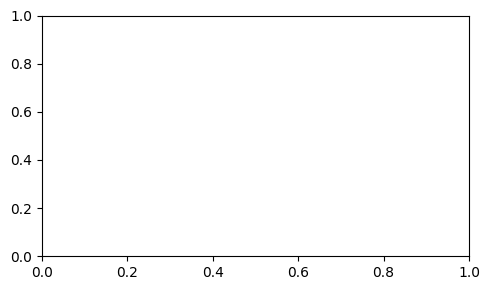

In [7]:
# Group by both second_variable_of_interest and variable_of_interest to compute mean and standard deviation of n_steps.
grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(
    ['median',  mad]
).reset_index()

# Determine unique second_variable_of_interest and variable_of_interest values.
second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

# Set up errorbar plot parameters.
n_groups = len(second_variable_of_interest_values)
n_series = len(variable_batch_values)
x = np.arange(n_groups)  # base x locations for groups

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
# Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
for i, mb in enumerate(variable_batch_values):
    subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
    means = []
    stds = []
    for ds in second_variable_of_interest_values:
        row = subset[subset[second_variable_of_interest] == ds]
        if not row.empty:
            means.append(row['median'].values[0])  # todo: median and mad
            stds.append(row['std'].values[0])
        else:
            means.append(np.nan)
            stds.append(0)

    # Use 'o-' for markers connected by lines.
    ax.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])

ax.axhline(max_steps, color='k', linestyle='--')
ax.text(0.1, max_steps-3500, f"Maximal Number of Steps", fontsize=8, color='k')

# Center the x-axis ticks and label them.
ax.set_xticks(x)
ax.set_xticklabels(second_variable_of_interest_values)
ax.set_xlabel(experiment_names[second_variable_of_interest])
ax.set_ylabel('Number of Steps')
#ax.set_title(f'Number of Steps by {experiment_names[second_variable_of_interest]} and {experiment_names[variable_of_interest]}')
ax.set_yscale('log')
ax.set_ylim(10, max_steps*2)
ax.legend(title=experiment_names[variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f'plots/{score_model_name}/{variable_of_interest}_n_steps.png', bbox_inches='tight')
plt.show()

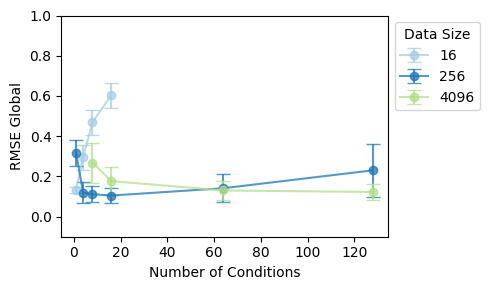

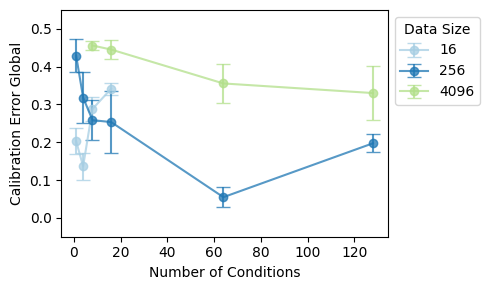

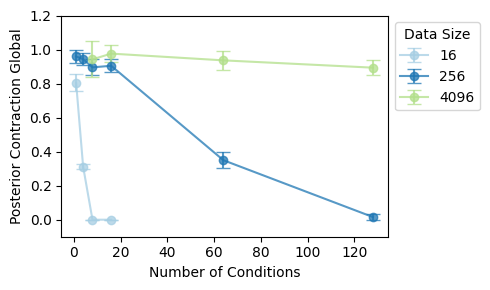

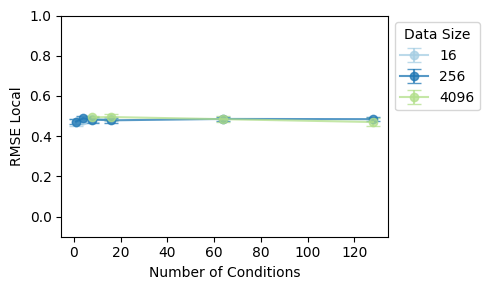

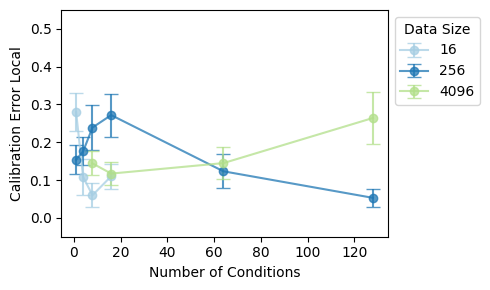

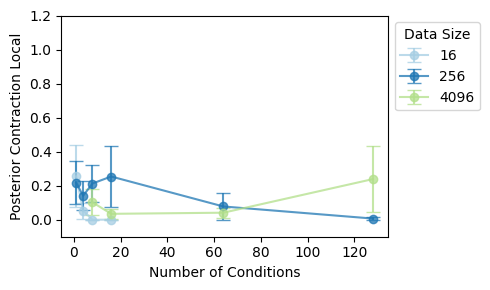

In [13]:
if variable_batch_values == 'mini_batch_size':
    # ------------------------------
    # Plot 1: Bar plot of n_steps for the full-batch  case.
    # ------------------------------

    # Filter the full-batch rows
    df_full = df_results[df_results['data_size'] == df_results['mini_batch']]

    # Group by data_size and compute mean and standard deviation of n_steps.
    grouped_full = df_full.groupby('data_size')['n_steps'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(4, 3), tight_layout=True)
    plt.bar(grouped_full['data_size'], grouped_full['mean'],
            yerr=grouped_full['std'], capsize=5, color='skyblue', edgecolor='black')
    plt.xlabel('Data Size')
    plt.ylabel('Number of Steps')
    plt.title('Number of Steps (Full Batch) per Data Size')
    plt.xticks(grouped_full['data_size'])
    plt.yscale('log')
    plt.xscale('log')
    plt.savefig(f'plots/{score_model_name}/{variable_of_interest}_steps_full_batch.png', bbox_inches='tight')
    plt.show()

# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. variable_of_interest.
# ------------------------------

# Filter rows with a variable_of_interest value (skip full-batch rows).
df_mb = df_results[df_results[variable_of_interest].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb[variable_of_interest] = df_mb[variable_of_interest].astype(float)

# Identify the unique data sizes (to plot different lines per data size).
unique_second_variable_of_interest = sorted(df_mb[second_variable_of_interest].unique())

# Create one figure per metric.
for metric, metric_label in metrics.items():
    plt.figure(figsize=(5, 3), tight_layout=True)
    for i, ds in enumerate(unique_second_variable_of_interest):
        # Select the rows for this particular data size.
        df_sub = df_mb[(df_mb[second_variable_of_interest] == ds) & (df_mb['n_steps'] != max_steps)]
        # Group by variable_of_interest size to get mean and std of the metric.
        grouped = df_sub.groupby(variable_of_interest)[metric].agg(['mean', 'std']).reset_index()
        if not np.isfinite(grouped['mean']).all() or grouped.empty:
            continue
        plt.errorbar(grouped[variable_of_interest], grouped['mean'], yerr=grouped['std'],
                     marker='o', capsize=5, label=f'{ds}', alpha=0.75, color=colors[i])
    plt.xlabel(experiment_names[variable_of_interest])
    plt.ylabel(metric_label)
    #plt.title(f'{metric_label} vs {experiment_names[variable_of_interest]}')
    plt.legend(title=experiment_names[second_variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    if metric == 'rel_contraction':
        plt.axhline(1, linestyle='--', color='k')
        if variable_of_interest == 'mini_batch':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'n_conditions':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'cosine_shift':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'damping_factor_t':
            plt.text(0.1, 1.05, f"Optimal", fontsize=8, color='k')

    if variable_of_interest == 'mini_batch' or variable_of_interest == 'damping_factor_t':
        plt.xscale('log')
    if metric == 'kl':
        plt.yscale('log')
    else:
        plt.ylim(y_limits[metric])
    plt.savefig(f'plots/{score_model_name}/{variable_of_interest}_{metric}.png', bbox_inches='tight')
    plt.show()

# Compare Number of Step per Information Unit

In [ ]:
variable_of_interest = 'mini_batch'
results_list = []
for m_id in m_ids:
    file_name = f'plots/{score_model_names(m_id, 1)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results_mini = pd.concat(results_list)
n_steps_raw = df_results_mini[['n_steps', 'data_size']].groupby('data_size').agg(['mean', 'std'])

variable_of_interest = 'n_conditions'
results_list = []
for m_id in m_ids:
    file_name = f'plots/{score_model_names(m_id, 128 if score_model_name[:2] == 'ar' else 100)}/df_results_{variable_of_interest}.csv'
    results_list.append(pd.read_csv(file_name, index_col=0))
df_results_cond = pd.concat(results_list)

In [ ]:
fig, axis = plt.subplots(ncols=2, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)

second_variable_of_interest = 'data_size'
axis[0].errorbar(n_steps_raw.index, n_steps_raw.n_steps.values[:, 0], yerr=n_steps_raw.n_steps.values[:, 1],
                 fmt='o-', capsize=5, alpha=0.75, color=colors[0])

for df_results, ax, variable_of_interest in zip([df_results_cond],
                                                [axis[-1]],
                                                ['n_conditions']):

    # Group by both second_variable_of_interest and variable_of_interest to compute mean and standard deviation of n_steps.
    grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(['mean','std']).reset_index()

    # Determine unique second_variable_of_interest and variable_of_interest values.
    second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
    variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

    # Set up errorbar plot parameters.
    n_groups = len(second_variable_of_interest_values)
    n_series = len(variable_batch_values)
    x = np.arange(n_groups)  # base x locations for groups

    # Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
    for i, mb in enumerate(variable_batch_values):
        subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
        means = []
        stds = []
        for ds in second_variable_of_interest_values:
            row = subset[subset[second_variable_of_interest] == ds]
            if not row.empty:
                means.append(row['mean'].values[0])
                stds.append(row['std'].values[0])
            else:
                means.append(np.nan)
                stds.append(0)

        means = np.array(means)
        means[means > max_steps] = max_steps

        # Center the x-axis ticks and label them.
        if variable_of_interest == 'n_conditions':
            ax.errorbar(second_variable_of_interest_values / mb, means,
                        yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
            #if i == 0:
            #    axis[0].errorbar(second_variable_of_interest_values / mb, means,
            #            yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
        else:
            # Use 'o-' for markers connected by lines.
            ax.errorbar(second_variable_of_interest_values, means, yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])

    ax.legend(title=experiment_names[variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))

for ax in axis:
    ax.axhline(max_steps, color='k', linestyle='--')
    ax.text(1, max_steps-3500, f"Maximal Number of Steps", fontsize=8, color='k')
    ax.set_xticks(second_variable_of_interest_values)
    ax.set_xticklabels(second_variable_of_interest_values)
    ax.set_xlabel('Information Units')
    ax.set_ylabel('Number of Steps')
    #ax.set_title(f'Number of Steps by {experiment_names[second_variable_of_interest]} and {experiment_names[variable_of_interest]}')
    ax.set_yscale('log')
    ax.set_xscale('log')


plt.savefig(f'plots/{score_model_name}/{variable_of_interest}_n_steps_conditions.png', bbox_inches='tight')
plt.show()